# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import selection
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

# Loading Datasets

In [5]:
df_train = pd.read_parquet('../data/processed/df_train_from_2.0_exploratory_data_analysis.parquet')
df_valid = pd.read_parquet('../data/processed/df_valid_from_2.0_exploratory_data_analysis.parquet')
df_oot = pd.read_parquet('../data/processed/df_oot_from_2.0_exploratory_data_analysis.parquet')

## Columns

In [6]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [7]:
df_valid.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [8]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 43695
Number of Cols: 147


In [10]:
print('Number of Rows: {}'.format(df_valid.shape[0]))
print('Number of Cols: {}'.format(df_valid.shape[1]))

Number of Rows: 34174
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18609
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_valid.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [14]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [15]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000046
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002609
customer_lng                                0.002609
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002563
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002586
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005126
distance_customer_seller_max                0.

In [16]:
df_valid.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002809
customer_lng                                0.002809
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002282
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002282
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005092
distance_customer_seller_max                0.

In [17]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000322
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002902
customer_lng                                0.002902
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001397
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001397
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004192
distance_customer_seller_max                0.

In [18]:
df_train = df_train.loc[df_train['delivered_in_days'].notna(), :]
df_valid = df_valid.loc[df_valid['delivered_in_days'].notna(), :]
df_oot = df_oot.loc[df_oot['delivered_in_days'].notna(), :]

## Splitting into X and y

In [19]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_valid = df_valid.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [20]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_valid = df_valid.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Fill NA

In [21]:
numerical_variables = X_train.select_dtypes(exclude='object').columns.tolist()
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()

In [22]:
median_imputer = imputation.MeanMedianImputer(imputation_method='median', variables=numerical_variables)
X_train = median_imputer.fit_transform(X_train)
X_valid = median_imputer.transform(X_valid)
X_oot = median_imputer.transform(X_oot)

In [23]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)
X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.transform(X_valid)
X_oot = cat_imputer.transform(X_oot)

## Categorical Encoding

In [24]:
cat_imputer = imputation.CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=categorical_variables)

X_train = cat_imputer.fit_transform(X_train)
X_valid = cat_imputer.fit_transform(X_valid)
X_oot = cat_imputer.fit_transform(X_oot)

In [25]:
rare_label_encoder = encoding.RareLabelEncoder(variables=categorical_variables)

X_train = rare_label_encoder.fit_transform(X_train)
X_valid = rare_label_encoder.transform(X_valid)
X_oot = rare_label_encoder.transform(X_oot)

The number of unique categories for variable payment_type_mode is less than that indicated in n_categories. Thus, all categories will be considered frequent


In [26]:
count_encoder = ce.CountEncoder(
    cols=None, return_df=True, handle_unknown='value', 
    handle_missing='value', normalize=True)

X_train[[c + '_ce' for c in categorical_variables]] = count_encoder.fit_transform(X_train[categorical_variables])
X_valid[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_ce' for c in categorical_variables]] = count_encoder.transform(X_oot[categorical_variables])

In [27]:
target_encoder = ce.TargetEncoder(
    cols=None, return_df=False, handle_missing='value', handle_unknown='value')

X_train[[c + '_te' for c in categorical_variables]] = target_encoder.fit_transform(X_train[categorical_variables], y_train[target])
X_valid[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_valid[categorical_variables])
X_oot[[c + '_te' for c in categorical_variables]] = target_encoder.transform(X_oot[categorical_variables])

## Cyclical Features

In [28]:
cyclical_variables = [
    'order_purchase_timestamp_second', 'order_purchase_timestamp_minute', 'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
    'order_approved_at_second', 'order_approved_at_minute', 'order_approved_at_hour', 'order_approved_at_day', 'order_approved_at_month']

cyclical_features = creation.CyclicalFeatures(variables=cyclical_variables, max_values=None, drop_original=False)
X_train = cyclical_features.fit_transform(X_train)
X_valid = cyclical_features.transform(X_valid)
X_oot = cyclical_features.transform(X_oot)

## Removing Features

In [29]:
drop_constant_features = selection.DropConstantFeatures(tol=.9, missing_values='include')
X_train = drop_constant_features.fit_transform(X_train)
X_valid = drop_constant_features.transform(X_valid)
X_oot = drop_constant_features.transform(X_oot)

# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [31]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()

X_train[categorical_columns] = X_train[categorical_columns].astype('category')
X_valid[categorical_columns] = X_valid[categorical_columns].astype('category')
X_oot[categorical_columns] = X_oot[categorical_columns].astype('category')

In [32]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 800, 'learning_rate': 0.009659826975897772, 'num_leaves': 339, 'subsample': 0.31025339632689986, 'colsample_bytree': 0.051792344913403954, 'min_data_in_leaf': 60}
Best RMSE: 9.168654885501192


In [33]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 800, 
    'learning_rate': 0.007980059085710783, 
    'num_leaves': 937, 
    'subsample': 0.1659376459058344, 
    'colsample_bytree': 0.05894547545316842, 
    'min_data_in_leaf': 65}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train, y_train[target], eval_set=(X_valid, y_valid[target]))

y_train['pred'] = lgbm.predict(X_train)
get_metrics(y_train[target], y_train['pred'])

R2: 0.3111925015032302; RMSE: 7.9834548301976; MAE: 4.581922547815506; MAPE: 10928958425250.48


In [34]:
y_valid['pred'] = lgbm.predict(X_valid)
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.2203547951115029; RMSE: 9.190013180844943; MAE: 5.863829454710274; MAPE: 60981231108779.625


In [35]:
y_oot['pred'] = lgbm.predict(X_oot)
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.04555541814039521; RMSE: 5.93776019855906; MAE: 4.625405898406552; MAPE: 138286453001279.52


### Feature Selection

In [50]:
smart_correlation_selection = selection.SmartCorrelatedSelection(
    estimator=LGBMRegressor(**params), method='pearson', threshold=0.8, missing_values='ignore', 
    selection_method='model_performance', scoring='r2', cv=3)

smart_correlation_selection.fit(X_train, y_train[target])
features_to_drop = smart_correlation_selection.features_to_drop_

In [51]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params))
sfm.fit(X_train.drop(features_to_drop, axis=1), y_train[target])

SelectFromModel(estimator=LGBMRegressor(bagging_freq=1,
                                        colsample_bytree=0.05894547545316842,
                                        learning_rate=0.007980059085710783,
                                        metric='rmse', min_data_in_leaf=65,
                                        n_estimators=800, num_leaves=937,
                                        objective='regression',
                                        subsample=0.1659376459058344,
                                        verbosity=-1))

In [52]:
list_selected_features = X_train.drop(features_to_drop, axis=1).loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_lat',
 'customer_lng',
 'distance_customer_seller_min',
 'payment_value_q75',
 'freight_value_mean',
 'product_name_lenght_q75',
 'product_description_lenght_q75',
 'product_weight_g_min',
 'product_length_cm_min',
 'product_height_cm_q25',
 'product_width_cm_q25',
 'order_purchase_until_approved_in_hours',
 'order_purchase_timestamp_second',
 'order_purchase_timestamp_minute',
 'order_purchase_timestamp_hour',
 'order_purchase_timestamp_day',
 'order_approved_at_second',
 'order_approved_at_hour',
 'order_purchase_timestamp_second_sin',
 'order_purchase_timestamp_second_cos',
 'order_purchase_timestamp_minute_sin',
 'order_purchase_timestamp_minute_cos',
 'order_purchase_timestamp_hour_cos',
 'order_purchase_timestamp_day_cos',
 'order_approved_at_second_cos',
 'order_approved_at_minute_sin',
 'order_approved_at_minute_cos',
 'order_approved_at_hour_sin',
 'order_approved_at_hour_cos',
 'order_approved_at_day_sin']

In [53]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.23279369707093356; RMSE: 8.425545346649397; MAE: 4.979570836121642; MAPE: 14860657340320.865


In [54]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.2059967754944676; RMSE: 9.27424920022243; MAE: 6.0466366902459185; MAPE: 62275954465394.78


In [55]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.25071400938642907; RMSE: 6.494236990462088; MAE: 5.366895695293123; MAPE: 174015757395881.4


### Second Hyperparamenter Tuning

In [56]:
def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1100, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)}

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train[target], eval_set=[(X_valid, y_valid[target])])
    
    pred = model.predict(X_valid)
    
    rmse = mean_squared_error(y_valid[target], pred, squared=False)
    
    return rmse


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 700, 'learning_rate': 0.030666176052870062, 'num_leaves': 3, 'subsample': 0.9978557468537215, 'colsample_bytree': 0.7210564432816291, 'min_data_in_leaf': 20}
Best RMSE: 9.135015157005661


In [57]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 700, 
    'learning_rate': 0.030666176052870062, 
    'num_leaves': 3, 
    'subsample': 0.9978557468537215, 
    'colsample_bytree': 0.7210564432816291, 
    'min_data_in_leaf': 20}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=[(X_valid[list_selected_features], y_valid[target])])

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.21308338298509244; RMSE: 8.533089433432753; MAE: 5.061934421915757; MAPE: 13234687881867.799


In [58]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.22813652057534017; RMSE: 9.144034892916785; MAE: 5.89491022097539; MAPE: 53859811549847.055


In [59]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.30060633768861345; RMSE: 6.622501400020826; MAE: 5.3939635609833925; MAPE: 154163561850809.88


# Result Analysis

## Final Model

In [33]:
list_selected_features = [
    'customer_lat',
    'customer_lng',
    'distance_customer_seller_min',
    'payment_value_q75',
    'freight_value_mean',
    'product_name_lenght_q75',
    'product_description_lenght_q75',
    'product_weight_g_min',
    'product_length_cm_min',
    'product_height_cm_q25',
    'product_width_cm_q25',
    'order_purchase_until_approved_in_hours',
    'order_purchase_timestamp_second',
    'order_purchase_timestamp_minute',
    'order_purchase_timestamp_hour',
    'order_purchase_timestamp_day',
    'order_approved_at_second',
    'order_approved_at_hour',
    'order_purchase_timestamp_second_sin',
    'order_purchase_timestamp_second_cos',
    'order_purchase_timestamp_minute_sin',
    'order_purchase_timestamp_minute_cos',
    'order_purchase_timestamp_hour_cos',
    'order_purchase_timestamp_day_cos',
    'order_approved_at_second_cos',
    'order_approved_at_minute_sin',
    'order_approved_at_minute_cos',
    'order_approved_at_hour_sin',
    'order_approved_at_hour_cos',
    'order_approved_at_day_sin']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'n_estimators': 700, 
    'learning_rate': 0.030666176052870062, 
    'num_leaves': 3, 
    'subsample': 0.9978557468537215, 
    'colsample_bytree': 0.7210564432816291, 
    'min_data_in_leaf': 20}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target], eval_set=(X_valid[list_selected_features], y_valid[target]))

y_train['pred'] = lgbm.predict(X_train[list_selected_features])
get_metrics(y_train[target], y_train['pred'])

R2: 0.21308338298509244; RMSE: 8.533089433432753; MAE: 5.061934421915757; MAPE: 13234687881867.799


In [34]:
y_valid['pred'] = lgbm.predict(X_valid[list_selected_features])
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.22813652057534017; RMSE: 9.144034892916785; MAE: 5.89491022097539; MAPE: 53859811549847.055


In [35]:
y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.30060633768861345; RMSE: 6.622501400020826; MAE: 5.3939635609833925; MAPE: 154163561850809.88


### Feature Importances

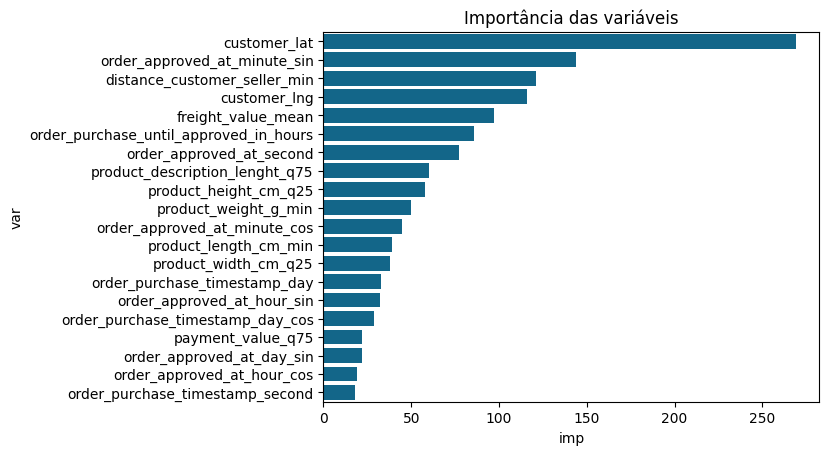

In [36]:
imp = pd.DataFrame(lgbm.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:20])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [37]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[list_selected_features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


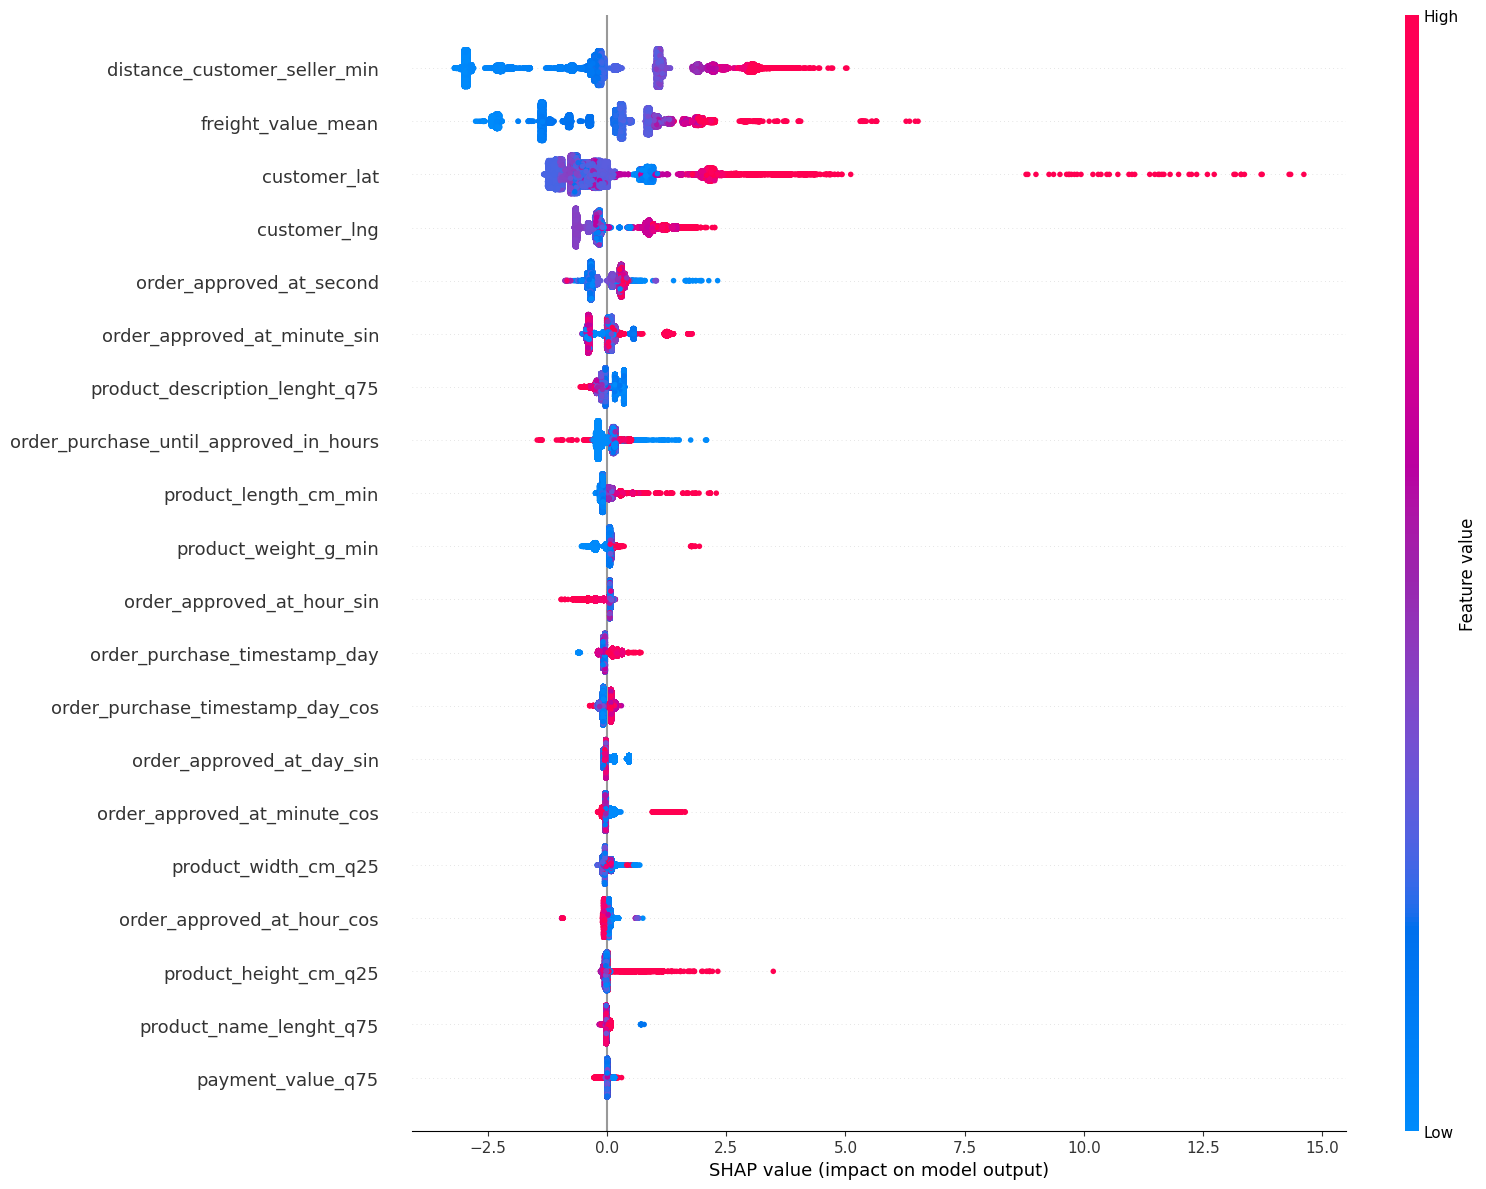

,index,impact
2,distance_customer_seller_min,1.398195
4,freight_value_mean,1.072584
0,customer_lat,0.850477
1,customer_lng,0.531833
16,order_approved_at_second,0.298612
25,order_approved_at_minute_sin,0.268507
6,product_description_lenght_q75,0.178887
11,order_purchase_until_approved_in_hours,0.164386
8,product_length_cm_min,0.121499
7,product_weight_g_min,0.117467


In [38]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df.head(15))

## Analysis of Estimated Values

### Train Values

In [39]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.633099685599317; RMSE: 15.609018303987078; MAE: 13.248082602623686; MAPE: 22992804709441.684


In [40]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.21308338298509244; RMSE: 8.533089433432753; MAE: 5.061934421915757; MAPE: 13234687881867.799


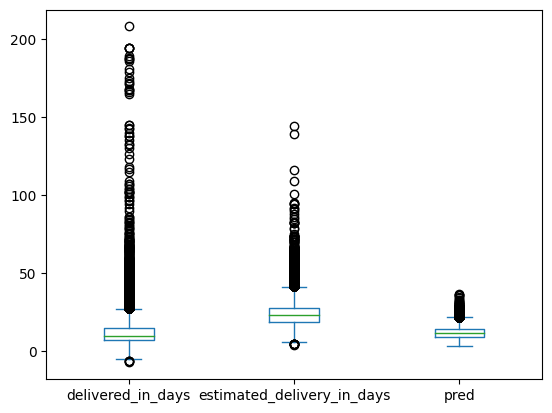

In [41]:
y_train.plot(kind='box');

### Valid Values

In [42]:
get_metrics(y_valid[target], y_valid['estimated_delivery_in_days'])

R2: -0.9082598350358131; RMSE: 14.377599535692035; MAE: 12.1404283958565; MAPE: 111884944216000.86


In [43]:
get_metrics(y_valid[target], y_valid['pred'])

R2: 0.22813652057534017; RMSE: 9.144034892916785; MAE: 5.89491022097539; MAPE: 53859811549847.055


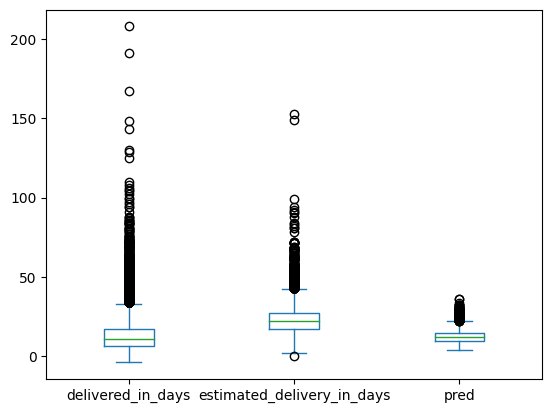

In [44]:
y_valid.plot(kind='box');

### OoT Values

In [45]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [46]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.30060633768861345; RMSE: 6.622501400020826; MAE: 5.3939635609833925; MAPE: 154163561850809.88


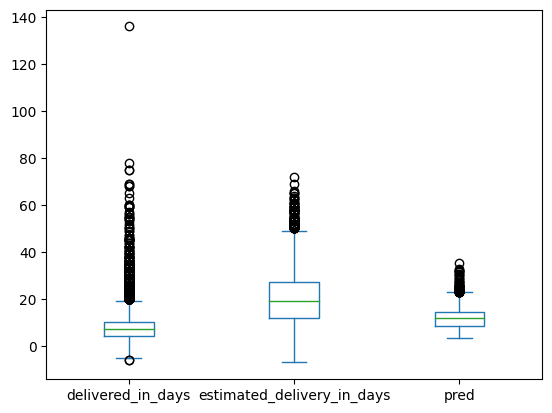

In [47]:
y_oot.plot(kind='box');

### Metrics over Time

In [48]:
df_aux = pd.concat([df_train[['time']], df_valid[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_train, y_valid, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

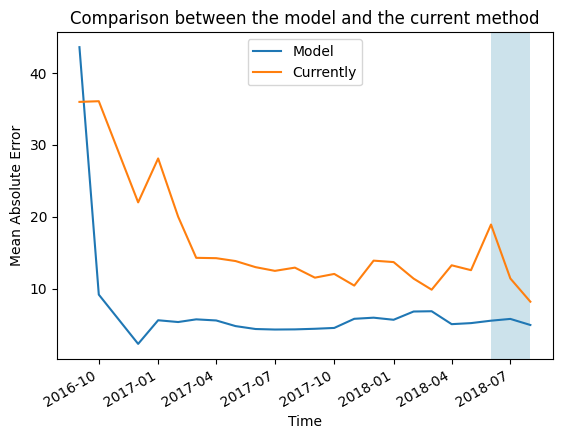

In [49]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

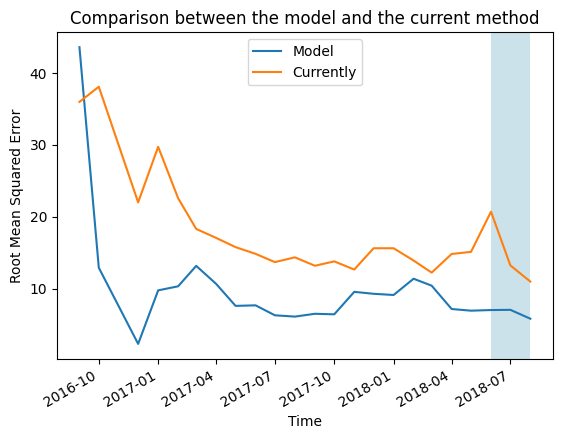

In [50]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');